In [ ]:
# Mount drive to save stuff there for later
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Upload kaggle api key
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Fetch train and test data from kaggle
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

! mkdir train
! unzip train.zip -d train > downloadlog.txt

! mkdir test
! unzip test.zip -d test >> downloadlog.txt

 95% 258M/271M [00:05<00:00, 51.9MB/s]
100% 271M/271M [00:06<00:00, 47.2MB/s]
 98% 532M/544M [00:10<00:00, 46.1MB/s]
100% 544M/544M [00:11<00:00, 51.3MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 99.5MB/s]


In [ ]:
import glob
import os
import cv2
import math
import datetime
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from pylab import rcParams

In [ ]:
# Check dirs on VM
os.listdir()

['.config',
 'test',
 'drive',
 'sample_submission.csv',
 'test.zip',
 'downloadlog.txt',
 'train.zip',
 'kaggle.json',
 'train',
 'sample_data']

In [ ]:
# Import UDFs
os.chdir('drive/My Drive/collab')
from helper_functions import *

In [ ]:
# Settings
INITIAL_TRAIN_DIR = 'train/train/' 
COMP_DIR = 'test/test/' 

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

np.random.seed(0)
tf.random.set_seed(0)

ROWS = 224
COLS = 224
CHANNELS = 3

MIN_LR = 0.00003 
MAX_LR = 0.00035 
BATCHSIZE = 32
CLR_METHOD = "triangular"
GAMMA = 0.99995
EPOCHS = 64
STEP_SIZE = 4 

rotation_range = 15
zoom_range = 0.15
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.15
horizontal_flip = True
fill_mode = "nearest"

experiment_name = 'larger_network_on224'
model_version = str(9)

rcParams['figure.figsize'] = 30, 6

In [ ]:
os.chdir('../../..')
X_files = np.array([INITIAL_TRAIN_DIR+i for i in os.listdir(INITIAL_TRAIN_DIR)])

# Get train and testset
X_train_filenames, X_test_filenames = train_test_split(X_files, test_size=0.1, random_state=0)

# Split traindata again into train and validation
X_train_filenames, X_val_filenames = train_test_split(X_train_filenames, test_size=0.1, random_state=0)

In [ ]:
sort_test_images(COMP_DIR)
prepare_file_structure(X_train_filenames, X_val_filenames, X_test_filenames)
show_directory_structure(startpath='data')

data/
   validation/
      dogs/
      cats/
   test/
      dogs/
      cats/
   train/
      dogs/
      cats/


In [ ]:
# Show examples of filenames
os.listdir('data/train/dogs/')[:5]

['dog.12373.jpg',
 'dog.2385.jpg',
 'dog.12331.jpg',
 'dog.10228.jpg',
 'dog.2839.jpg']

In [ ]:
# Create model
model = initialize_simplified_VGG(ROWS, COLS, CHANNELS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       7

In [ ]:
# save best model checkpoint
save_model = tf.keras.callbacks.ModelCheckpoint('drive/My Drive/collab/vgg16_' + experiment_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                                                save_weights_only=False, mode='auto', save_freq='epoch')

# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# Cyclical learning rate callback
clr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR, step_size=STEP_SIZE * -(-len(X_train_filenames)//BATCHSIZE), mode=CLR_METHOD, gamma=GAMMA)

# Create tensorboard callback
log_dir = "drive/My Drive/collab/logs/fit/" + experiment_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create augmentation generator
train_aug = ImageDataGenerator(
		rescale=1./255,
    rotation_range=rotation_range,
		zoom_range=zoom_range,
		width_shift_range=width_shift_range,
		height_shift_range=height_shift_range,
		shear_range=shear_range,
		horizontal_flip=horizontal_flip,
		fill_mode=fill_mode
)

test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(train_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
val_generator = test_aug.flow_from_directory(validation_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
test_generator = test_aug.flow_from_directory(test_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)
comp_generator = test_aug.flow_from_directory('test', target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
# Train model
start = datetime.datetime.now()
print(start)

history = model.fit(train_generator,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[clr, early, save_model, tensorboard_callback]
                ) 

print('Finished in: {}'.format(datetime.datetime.now() - start))
print(datetime.datetime.now())

2020-10-19 16:39:47.169806
Epoch 1/64
  1/633 [..............................] - ETA: 0s - loss: 0.6935 - accuracy: 0.4375WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
633/633 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.5599
Epoch 00001: val_loss improved from inf to 0.62683, saving model to drive/My Drive/collab/vgg16_larger_network_on224.h5
633/633 [==============================] - 269s 425ms/step - loss: 0.6798 - accuracy: 0.5599 - val_loss: 0.6268 - val_accuracy: 0.6604
Epoch 2/64
633/633 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.6269
Epoch 00002: val_loss improved from 0.62683 to 0.60144, saving model to drive/My Drive/collab/vgg16_larger_network_on224.h5
633/633 [==============================]

In [ ]:
# Remove old logs from tensorboard
# ! rm -rf "./drive/My Drive/collab/logs/"

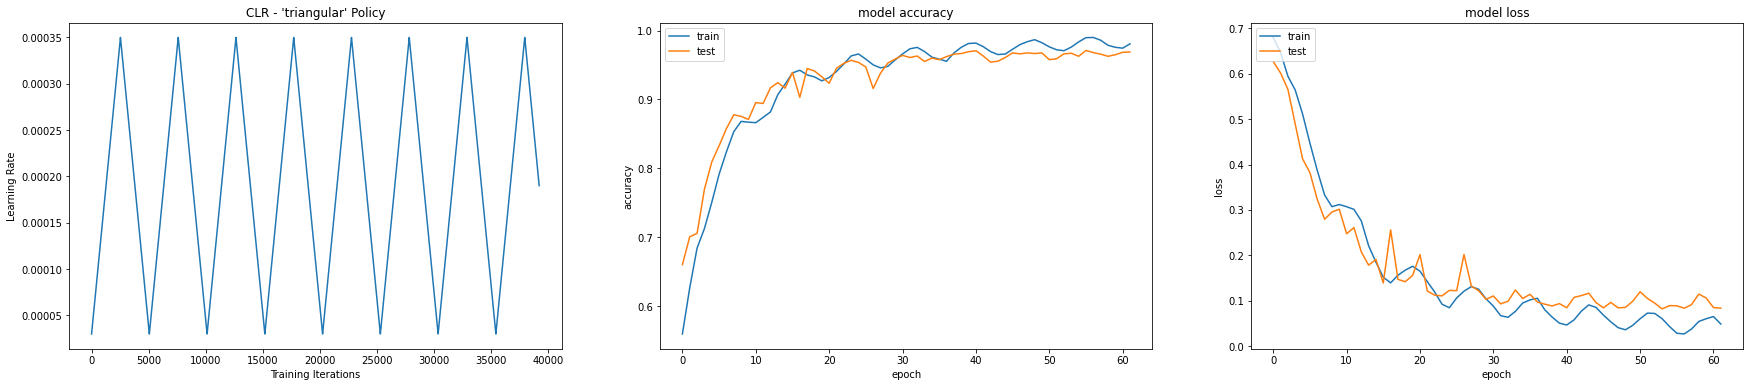

In [ ]:
training_history_plots(history, clr)

In [ ]:
# read in best version of model here
model = tf.keras.models.load_model('drive/My Drive/collab/vgg16_' + model_version + '.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

79/79 [==============================] - 8s 96ms/step - loss: 0.0845 - accuracy: 0.9704


In [ ]:
# preds = []
# actuals = []
# for i in range(78):
#     X, y = test_generator.next()
#     prediction = model.predict(X)
#     preds.append(list(np.round(prediction[:, 1])))
#     actuals.append(list(y))

# actuals = [item for sublist in actuals for item in sublist]
# preds = [item for sublist in preds for item in sublist]
# print('Accuracy score: {}'.format(accuracy_score(actuals, preds)))
# confusion_matrix(actuals, preds)

In [ ]:
# Load some images to see if everything went right
test_images = [COMP_DIR + x for x in os.listdir(COMP_DIR)]
test_images.sort()
comp_data = prep_data(test_images[:9], ROWS, COLS, CHANNELS)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(comp_data[i])

In [ ]:
predictions_comp_data = pd.DataFrame({'id': range(1, len(os.listdir(COMP_DIR)) + 1), 'label': np.clip(model.predict(comp_generator)[:, 1], 0.02, 0.98)})
predictions_comp_data['label'] = round(predictions_comp_data['label'], 4)
predictions_comp_data.head(9)

In [ ]:
predictions_comp_data.describe()

In [ ]:
submission_path = 'drive/My Drive/collab/submission_simple_vgg' + str(8) + '.csv'
predictions_comp_data.to_csv(submission_path, index=False)

In [ ]:
! kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f 'drive/My Drive/collab/submission_simple_vgg8.csv' -m "image size 224 px, clip 0.02"